In [5]:
# Importation des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
import argparse

# Données
import wrds

In [6]:
# Enlever tous les messages de prévention sous les résultats 
import warnings
warnings.filterwarnings('ignore')

## Préparation des données DEVISES

In [7]:
currencies = pd.read_csv('currencies.csv')
currencies['date'] = pd.to_datetime(currencies['date'])

currencies

,date,dexalus,dexcaus,dexjpus,dexszus,dexukus
0,2005-01-03,1.283697,1.2108,102.83,1.1466,0.524714
1,2005-01-04,1.304121,1.2248,104.27,1.1674,0.530955
2,2005-01-05,1.302423,1.2236,103.95,1.1673,0.529801
3,2005-01-06,1.313715,1.2371,104.87,1.1733,0.533305
4,2005-01-07,1.319261,1.2333,104.93,1.1859,0.534702
...,...,...,...,...,...,...
5212,2024-12-25,NaN,NaN,NaN,NaN,NaN
5213,2024-12-26,1.605910,1.4404,158.01,0.9000,0.798594
5214,2024-12-27,1.610825,1.4433,157.73,0.9018,0.795355
5215,2024-12-30,1.607976,1.4374,157.26,0.9066,0.798531


In [8]:
# Renommer colonnes
currencies.columns = ['date', 'Australia', 'Canada', 'Japan', 'Switzerland', 'UK']
currencies

,date,Australia,Canada,Japan,Switzerland,UK
0,2005-01-03,1.283697,1.2108,102.83,1.1466,0.524714
1,2005-01-04,1.304121,1.2248,104.27,1.1674,0.530955
2,2005-01-05,1.302423,1.2236,103.95,1.1673,0.529801
3,2005-01-06,1.313715,1.2371,104.87,1.1733,0.533305
4,2005-01-07,1.319261,1.2333,104.93,1.1859,0.534702
...,...,...,...,...,...,...
5212,2024-12-25,NaN,NaN,NaN,NaN,NaN
5213,2024-12-26,1.605910,1.4404,158.01,0.9000,0.798594
5214,2024-12-27,1.610825,1.4433,157.73,0.9018,0.795355
5215,2024-12-30,1.607976,1.4374,157.26,0.9066,0.798531


In [9]:
# Nettoyage + fréquence données 

currencies_daily = currencies.dropna()

print(f"Nombre observations avant nettoyage : {len(currencies)}")
print(f"Nombre observations après nettoyage : {len(currencies_daily)}")
print(f"Nombre observations supprimées : {len(currencies) - len(currencies_daily)}")

print(f"\nDate de début : {currencies_daily['date'].min()}")
print(f"Date de fin : {currencies_daily['date'].max()}\n")
print(f"Durée totale : {(currencies_daily['date'].max() - currencies_daily['date'].min()).days} jours\n")

currencies_daily.info()

Nombre observations avant nettoyage : 5217
Nombre observations après nettoyage : 5011
Nombre observations supprimées : 206

Date de début : 2005-01-03 00:00:00
Date de fin : 2024-12-31 00:00:00

Durée totale : 7302 jours

<class 'pandas.core.frame.DataFrame'>
Index: 5011 entries, 0 to 5216
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5011 non-null   datetime64[ns]
 1   Australia    5011 non-null   float64       
 2   Canada       5011 non-null   float64       
 3   Japan        5011 non-null   float64       
 4   Switzerland  5011 non-null   float64       
 5   UK           5011 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 274.0 KB


In [10]:
currencies_daily

,date,Australia,Canada,Japan,Switzerland,UK
0,2005-01-03,1.283697,1.2108,102.83,1.1466,0.524714
1,2005-01-04,1.304121,1.2248,104.27,1.1674,0.530955
2,2005-01-05,1.302423,1.2236,103.95,1.1673,0.529801
3,2005-01-06,1.313715,1.2371,104.87,1.1733,0.533305
4,2005-01-07,1.319261,1.2333,104.93,1.1859,0.534702
...,...,...,...,...,...,...
5211,2024-12-24,1.605136,1.4383,157.29,0.9009,0.798212
5213,2024-12-26,1.605910,1.4404,158.01,0.9000,0.798594
5214,2024-12-27,1.610825,1.4433,157.73,0.9018,0.795355
5215,2024-12-30,1.607976,1.4374,157.26,0.9066,0.798531


### Justification du choix des données

**Pays d'origine** : USD (États-Unis)
- Toutes les paires de devises utilisent le dollar américain comme monnaie d'origine
- Ceci permet une analyse cohérente et facilite la comparaison entre devises

**Choix des 5 devises** :
1. **Brazil (BRL)** : Économie émergente d'Amérique du Sud, fortement influencée par les matières premières
2. **Canada (CAD)** : Économie développée, fortement liée aux États-Unis (commerce ALENA/ACEUM)
3. **Mexico (MXN)** : Économie émergente, également intégrée dans l'ACEUM
4. **UK (GBP)** : Économie européenne majeure, centre financier important (Brexit après 2016)
5. **EU (EUR)** : Zone euro, représentant la 2e plus grande économie mondiale

**Justification de la période** :
- Les données couvrent une période longue permettant de capturer différents cycles économiques
- Période suffisante pour analyser les relations macroéconomiques à basse fréquence
- Inclut des événements majeurs : crise de 2008, crise dette européenne, Brexit, COVID-19

**Fréquence** : 
- Les données brutes sont quotidiennes (jours ouvrables)
- Pour l'analyse factorielle, nous convertirons en fréquence **mensuelle** pour correspondre à la disponibilité des données macroéconomiques (PIB, inflation, taux d'intérêt, etc.)

## Conversion en fréquence mensuelle

In [11]:
# Recharger les données nettoyées pour éviter les problèmes de réexécution
currencies_temp = currencies.dropna().copy()

# Supprimer la colonne year temporaire si elle existe
if 'year' in currencies_temp.columns:
    currencies_temp = currencies_temp.drop('year', axis=1)

# Définir la date comme index
currencies_temp = currencies_temp.set_index('date')

# Rééchantillonner à fréquence mensuelle (dernier jour du mois)
currencies_monthly = currencies_temp.resample('ME').last()

# Supprimer les valeurs manquantes qui pourraient être créées
currencies_monthly = currencies_monthly.dropna()

print(f"Observations quotidiennes : {len(currencies_temp)}")
print(f"Observations mensuelles : {len(currencies_monthly)}")
print(f"Période : {currencies_monthly.index.min()} à {currencies_monthly.index.max()}")
print(f"Nombre d'années : {(currencies_monthly.index.max() - currencies_monthly.index.min()).days / 365.25:.1f}")

currencies_monthly.info()

Observations quotidiennes : 5011
Observations mensuelles : 240
Période : 2005-01-31 00:00:00 à 2024-12-31 00:00:00
Nombre d'années : 19.9
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 2005-01-31 to 2024-12-31
Freq: ME
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Australia    240 non-null    float64
 1   Canada       240 non-null    float64
 2   Japan        240 non-null    float64
 3   Switzerland  240 non-null    float64
 4   UK           240 non-null    float64
dtypes: float64(5)
memory usage: 11.2 KB


## Calcul des rendements logarithmiques

Les rendements logarithmiques sont préférés pour l'analyse car :
- Ils sont additifs dans le temps
- Ils ont de meilleures propriétés statistiques
- Ils sont symétriques pour les hausses et baisses
- Formule : $r_t = \ln(S_t / S_{t-1}) = \ln(S_t) - \ln(S_{t-1})$

In [40]:
# Calculer les rendements logarithmiques mensuels
returns = np.log(currencies_monthly / currencies_monthly.shift(1))

returns = returns.dropna()

# Convertir l'index en colonne pour faciliter les futures fusions
returns = returns.reset_index().rename(columns={'index': 'date'})

print(f"Nombre d'observations de rendements : {len(returns)}")
print(f"\nStatistiques descriptives des rendements mensuels :")
print(returns.describe())

Nombre d'observations de rendements : 239

Statistiques descriptives des rendements mensuels :
                                date   Australia      Canada       Japan  \
count                            239  239.000000  239.000000  239.000000   
mean   2015-01-29 20:35:08.786610944    0.000949    0.000627    0.001751   
min              2005-02-28 00:00:00   -0.088366   -0.085832   -0.075052   
25%              2010-02-14 00:00:00   -0.022536   -0.014970   -0.014262   
50%              2015-01-31 00:00:00    0.001297   -0.000443   -0.000246   
75%              2020-01-15 12:00:00    0.021490    0.015222    0.019080   
max              2024-12-31 00:00:00    0.184246    0.137416    0.084550   
std                              NaN    0.035571    0.025482    0.027461   

       Switzerland          UK  
count   239.000000  239.000000  
mean     -0.001129    0.001712  
min      -0.130846   -0.087979  
25%      -0.017888   -0.016751  
50%      -0.001204    0.001303  
75%       0.016745    

In [46]:
returns

,date,Australia,Canada,Japan,Switzerland,UK
0,2005-02-28,-0.023060,-0.008181,0.006737,-0.024893,-0.020946
1,2005-03-31,0.026934,-0.016483,0.028091,0.031187,0.018932
2,2005-04-30,-0.013494,0.038444,-0.024357,-0.004528,-0.012313
3,2005-05-31,0.031510,-0.004466,0.031328,0.045109,0.047716
4,2005-06-30,-0.003551,-0.020673,0.026866,0.030073,0.016648
...,...,...,...,...,...,...
234,2024-08-31,-0.034590,-0.022932,-0.029901,-0.035168,-0.022487
235,2024-09-30,-0.024675,0.001333,-0.018673,-0.005786,-0.020128
236,2024-10-31,0.056972,0.031186,0.061589,0.023872,0.041369
237,2024-11-30,0.005665,0.005366,-0.012816,0.019921,0.012287


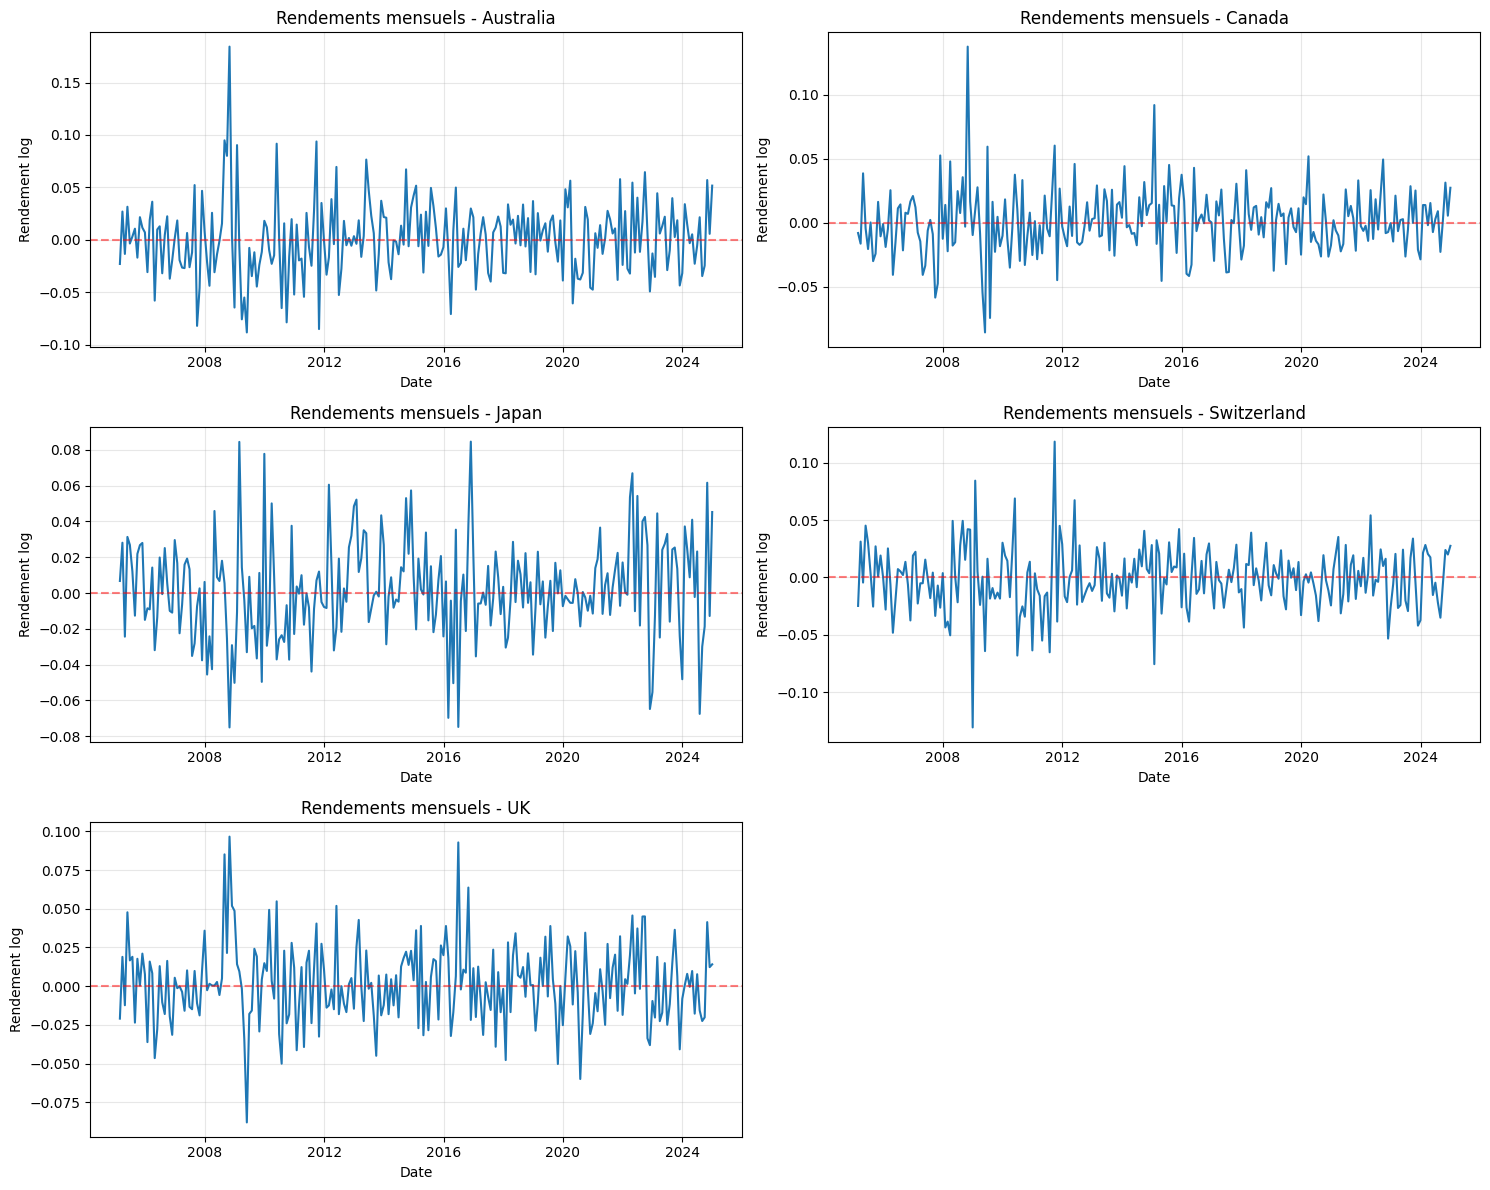

In [14]:
# Visualiser les rendements
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(returns.columns):
    axes[i].plot(returns.index, returns[col])
    axes[i].set_title(f'Rendements mensuels - {col}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Rendement log')
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Masquer le dernier subplot (6ème)
axes[5].axis('off')

plt.tight_layout()
plt.show()

# Préparation des données FACTORIELLES

Facteurs recommandés
1. Facteurs de Taux d'Intérêt (ESSENTIEL)
Taux sans risque (Treasury bills, obligations gouvernementales court terme) pour chaque pays
Différentiel de taux d'intérêt entre USD et chaque devise
Justification : Le carry trade est un déterminant majeur des rendements de devises. Les investisseurs empruntent dans des devises à faible taux et investissent dans des devises à taux élevé.

2. Facteurs d'Inflation
Taux d'inflation (CPI - Consumer Price Index) pour chaque pays
Différentiel d'inflation entre USA et chaque pays
Justification : Parité du pouvoir d'achat (PPP) - les différentiels d'inflation affectent les taux de change à long terme.

3. Facteurs de Croissance Économique
Croissance du PIB (trimestrielle ou annuelle convertie en mensuelle)
Différentiel de croissance entre pays
Justification : La force économique relative influence les flux de capitaux et donc les devises.

4. Facteur de Risque Global (Market Risk)
VIX (Volatility Index) - mesure de l'aversion au risque global
Ou indice boursier américain (S&P 500) comme proxy du risque de marché
Justification : En période de stress, les investisseurs fuient vers les valeurs refuges (USD, peut-être EUR), créant un facteur commun.

5. Facteurs de Matières Premières (Important pour Brazil, Canada, Mexico)
Prix du pétrole (WTI ou Brent)
Indice des matières premières (CRB Index)
Justification : Brazil, Canada et Mexico sont des exportateurs de ressources naturelles. Leurs devises sont fortement corrélées aux prix des commodités.

6. Balance Commerciale / Compte Courant
Balance commerciale ou compte courant en % du PIB
Justification : Les flux commerciaux créent de l'offre et demande pour les devises.

🎯 Facteurs PRIORITAIRES (à télécharger absolument)
Différentiels de taux d'intérêt (carry factor)
VIX ou équivalent (risk-off factor)
Prix du pétrole (commodity factor)
Différentiels d'inflation
💡 Stratégie recommandée
Compte tenu de la nature bilatérale mentionnée dans l'introduction :

Ne pas utiliser les niveaux absolus, mais les DIFFÉRENTIELS (USA vs autre pays)
Exemple : Taux_Canada - Taux_USA, Inflation_Brazil - Inflation_USA
Cela capture l'essence bilatérale : ce qui compte, c'est la différence relative


## FACTEUR 1: Taux Intérêts

Mentionner que "conversion des dates en fin de mois" pour que ça puisse s'aligner avec nos données de rendements

In [89]:
# Fichiers des taux d'intérêt (5 devises + USA)
interest_files = {
    'Australia': 'IR_AU.csv',
    'Canada': 'IR_CA.csv',
    'Japan': 'IR_JA.csv',
    'Switzerland': 'IR_SW.csv',
    'UK': 'IR_UK.csv',
    'US': 'IR_US.csv'  # Ajout des taux US pour calculer les différentiels
}

# Charger tous les fichiers
interest_rates = {}
for country, filename in interest_files.items():
    df = pd.read_csv(filename)
    df.columns = ['date', country]
    df['date'] = pd.to_datetime(df['date'])
    interest_rates[country] = df
    print(f"{country}: {len(df)} observations")

interest_rates

Australia: 240 observations
Canada: 240 observations
Japan: 240 observations
Switzerland: 240 observations
UK: 240 observations
US: 240 observations


{'Australia':           date  Australia
 0   2005-01-01       5.42
 1   2005-02-01       5.63
 2   2005-03-01       5.81
 3   2005-04-01       5.75
 4   2005-05-01       5.68
 ..         ...        ...
 235 2024-08-01       4.38
 236 2024-09-01       4.42
 237 2024-10-01       4.41
 238 2024-11-01       4.42
 239 2024-12-01       4.44
 
 [240 rows x 2 columns],
 'Canada':           date  Canada
 0   2005-01-01  2.4550
 1   2005-02-01  2.4450
 2   2005-03-01  2.4980
 3   2005-04-01  2.4700
 4   2005-05-01  2.4600
 ..         ...     ...
 235 2024-08-01  4.2325
 236 2024-09-01  4.0425
 237 2024-10-01  3.7100
 238 2024-11-01  3.4800
 239 2024-12-01  3.1950
 
 [240 rows x 2 columns],
 'Japan':           date  Japan
 0   2005-01-01  0.100
 1   2005-02-01  0.100
 2   2005-03-01  0.080
 3   2005-04-01  0.080
 4   2005-05-01  0.080
 ..         ...    ...
 235 2024-08-01  0.255
 236 2024-09-01  0.256
 237 2024-10-01  0.256
 238 2024-11-01  0.362
 239 2024-12-01  0.386
 
 [240 rows x 2 columns],

### Étape 2 : Fusionner tous les taux d'intérêt (incluant USA)

On fusionne tous les taux d'intérêt (5 pays + USA) dans un seul DataFrame.
Les taux US serviront à calculer les **différentiels bilatéraux** : $IR_{pays} - IR_{US}$

In [90]:
# Fusionner tous les taux dans un seul DataFrame (incluant USA)
# Commencer avec le premier pays
rates_combined = interest_rates['Australia'].copy()

# Ajouter les autres pays un par un (incluant USA)
for country in ['Canada', 'Japan', 'Switzerland', 'UK', 'US']:
    rates_combined = rates_combined.merge(
        interest_rates[country], 
        on='date', 
        how='inner'
    )

# Trier par date
rates_combined = rates_combined.sort_values('date').reset_index(drop=True)

# Convertir les dates en fin de mois pour aligner avec currencies_monthly
rates_combined['date'] = pd.to_datetime(rates_combined['date']) + pd.offsets.MonthEnd(0)

print(f"Nombre de donnée par pays: {len(rates_combined)} observations")
print(f"Période : {rates_combined['date'].min()} à {rates_combined['date'].max()}")
print(f"\nValeurs manquantes : {rates_combined.isnull().sum().sum()}")

rates_combined

Nombre de donnée par pays: 240 observations
Période : 2005-01-31 00:00:00 à 2024-12-31 00:00:00

Valeurs manquantes : 1


,date,Australia,Canada,Japan,Switzerland,UK,US
0,2005-01-31,5.42,2.4550,0.100,0.651069,4.87316,2.61
1,2005-02-28,5.63,2.4450,0.100,0.677186,4.89069,2.77
2,2005-03-31,5.81,2.4980,0.080,0.666316,4.98736,2.97
3,2005-04-30,5.75,2.4700,0.080,0.672952,4.94336,3.09
4,2005-05-31,5.68,2.4600,0.080,0.670662,4.89375,3.22
...,...,...,...,...,...,...,...
235,2024-08-31,4.38,4.2325,0.255,1.066472,4.91000,5.12
236,2024-09-30,4.42,4.0425,0.256,1.022143,4.84000,4.86
237,2024-10-31,4.41,3.7100,0.256,0.894493,4.75000,4.62
238,2024-11-30,4.42,3.4800,0.362,0.806508,4.68000,4.53


### Étape 3 : Calcul des différentiels bilatéraux

Pour capturer les **effets bilatéraux** (les deux pays comptent pour le taux de change), nous calculons :
$$\Delta IR_{pays} = IR_{pays} - IR_{US}$$

Cette approche est justifiée par la **Parité des Taux d'Intérêt Non Couverte (UIP)** : c'est le **différentiel de taux** qui influence les mouvements de change, pas les taux absolus.

In [91]:
# Calculer les différentiels de taux d'intérêt (Pays - USA)
dates_ir = rates_combined['date'].copy()

# Créer le DataFrame des différentiels en niveaux
ir_differentials = pd.DataFrame()
for country in ['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']:
    ir_differentials[country] = rates_combined[country] - rates_combined['US']

# Calculer les CHANGEMENTS des différentiels (en points de %, pas en % de variation)
# Cela évite les divisions par zéro quand le différentiel est proche de zéro
ir_returns = ir_differentials.diff()

# Réattacher les dates
ir_returns.insert(0, 'date', dates_ir)

# Supprimer la première ligne (NaN)
ir_returns = ir_returns.dropna()

print(f"📊 Changements des différentiels de taux d'intérêt (Pays - USA) :")
print(f"Unité : Points de pourcentage")
print(f"Nombre d'observations : {len(ir_returns)}")
print(f"Période : {ir_returns['date'].min()} à {ir_returns['date'].max()}")
print(f"\nStatistiques descriptives des changements (en points de %) :")
print(ir_returns.drop('date', axis=1).describe())

📊 Changements des différentiels de taux d'intérêt (Pays - USA) :
Unité : Points de pourcentage
Nombre d'observations : 237
Période : 2005-02-28 00:00:00 à 2024-12-31 00:00:00

Statistiques descriptives des changements (en points de %) :
        Australia      Canada       Japan  Switzerland          UK
count  237.000000  237.000000  237.000000   237.000000  237.000000
mean    -0.015105   -0.007816   -0.011376    -0.013046   -0.012925
std      0.233682    0.237355    0.222355     0.212170    0.151414
min     -1.970000   -1.291500   -0.780000    -1.443862   -0.684370
25%     -0.090000   -0.072500   -0.060000    -0.083266   -0.066010
50%     -0.010000    0.000000   -0.008180    -0.001267    0.000000
75%      0.060000    0.046000    0.030000     0.051589    0.040000
max      1.290000    2.186500    1.950000     1.249527    0.762370


In [92]:
ir_returns

,date,Australia,Canada,Japan,Switzerland,UK
1,2005-02-28,0.05,-0.1700,-0.160,-0.133883,-0.14247
2,2005-03-31,-0.02,-0.1470,-0.220,-0.210870,-0.10333
3,2005-04-30,-0.18,-0.1480,-0.120,-0.113364,-0.16400
4,2005-05-31,-0.20,-0.1400,-0.130,-0.132290,-0.17961
5,2005-06-30,-0.18,-0.1720,-0.150,-0.158461,-0.21231
...,...,...,...,...,...,...
235,2024-08-31,0.11,-0.0855,0.279,0.062994,0.01000
236,2024-09-30,0.30,0.0700,0.261,0.215670,0.19000
237,2024-10-31,0.23,-0.0925,0.240,0.112350,0.15000
238,2024-11-30,0.10,-0.1400,0.196,0.002015,0.02000


### Note méthodologique : Pourquoi des différences absolues plutôt que des variations en pourcentage ?

**Problème évité** : Division par zéro et valeurs infinies

Lorsqu'on calcule des différentiels de taux d'intérêt $(IR_{pays} - IR_{US})$, il peut arriver que :
- Les deux pays aient des taux identiques ou très proches → **différentiel ≈ 0**
- Appliquer `.pct_change() * 100` sur un différentiel proche de zéro → **division par zéro → `inf`**

**Exemple problématique** :
```
Mois 1 : Canada 2.5%, USA 2.5% → Différentiel = 0.0%
Mois 2 : Canada 2.6%, USA 2.5% → Différentiel = 0.1%
Variation % = (0.1 - 0.0) / 0.0 × 100 = inf  ⚠️
```

**Solution adoptée : `.diff()` au lieu de `.pct_change() * 100`**

Nous calculons les **changements absolus** (en points de pourcentage) :
$$\Delta(\text{Différentiel})_t = (IR_{pays,t} - IR_{US,t}) - (IR_{pays,t-1} - IR_{US,t-1})$$

**Avantages** :
1. ✅ **Pas de division par zéro** : Calcul toujours défini
2. ✅ **Interprétation claire** : Un changement de +0.25 = le différentiel a augmenté de 0.25 points de %
3. ✅ **Comparabilité** : Tous les pays ont la même unité (points de %)
4. ✅ **Cohérence théorique** : C'est le changement du différentiel qui compte pour les flux de capitaux (UIP)

**Valeurs typiques** : Entre -0.5 et +0.5 points de % par mois, avec quelques pics durant les crises (jusqu'à ±2 points).

### Étape 4 : Visualisation des séries temporelles

Graphiques des **changements** des différentiels de taux d'intérêt (Pays - USA) dans le temps.
Unité : Points de pourcentage (variation absolue, pas variation en %)

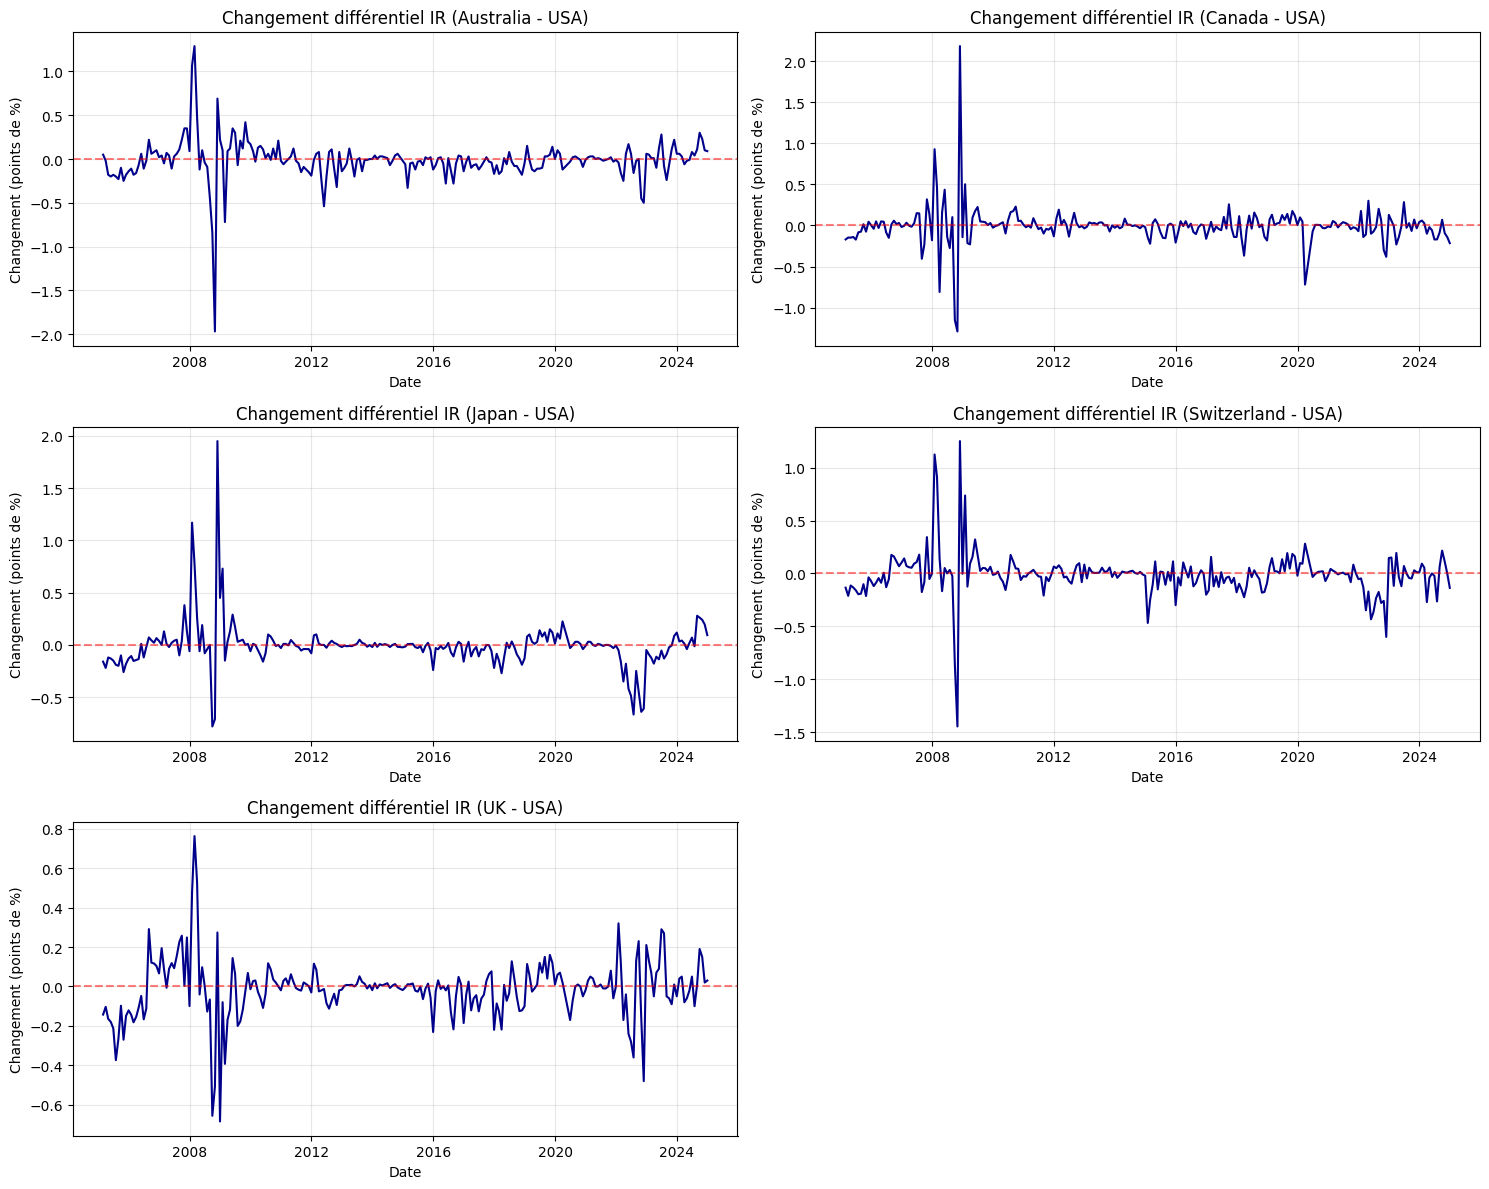

In [106]:
# Visualiser les changements des différentiels de taux d'intérêt
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(ir_returns.drop('date', axis=1).columns):
    axes[i].plot(ir_returns['date'], ir_returns[col], color='darkblue')
    axes[i].set_title(f'Changement différentiel IR ({col} - USA)')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Changement (points de %)')
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Masquer le dernier subplot (6ème)
axes[5].axis('off')

plt.tight_layout()
plt.show()

Interprétation des graphiques de changements de différentiels
Ce que montrent les graphiques :
Chaque graphique affiche l'évolution mensuelle du changement du différentiel (Pays - USA) sur 20 ans.

Lecture des graphiques :
Ligne au-dessus de zéro (positive) :

Le différentiel s'est élargi ce mois-là
Le pays s'est éloigné des USA (taux plus élevés ou REER plus fort)
Pour IR : Pays devient plus attractif pour le carry trade
Pour REER : Pays devient plus surévalué relativement aux USA
Ligne en-dessous de zéro (négative) :

Le différentiel s'est réduit ce mois-là
Le pays s'est rapproché des USA (convergence des taux ou REER)
Pour IR : Pays devient moins attractif pour le carry trade
Pour REER : Pays devient moins surévalué relativement aux USA
Ligne sur zéro :

Le différentiel n'a pas changé ce mois-là
Stabilité relative entre les deux pays
Patterns à observer :
Volatilité : Pays avec grandes oscillations = politique monétaire/valorisation instable
Périodes de clustering : Plusieurs mois consécutifs positifs/négatifs = tendances persistantes
Pics extrêmes : Crises économiques (2008, COVID) → changements brutaux de politiques
Moyennes : Si souvent au-dessus/en-dessous de zéro = tendance long terme
Exemple concret (Taux d'intérêt Canada) :
Si vous voyez un pic à +0.3 en mars 2020 :

"En mars 2020, le différentiel Canada-USA s'est élargi de 0.3 points. Cela signifie que la Banque du Canada a baissé ses taux moins vite que la Fed pendant la crise COVID, rendant le CAD temporairement plus attractif."

#### OPTIONNEL POUR ANALYSE

In [107]:
# Statistiques descriptives des taux d'intérêt
print("Statistiques descriptives des taux d'intérêt :")
print(rates_combined.drop('date', axis=1).describe())

rates_combined

Statistiques descriptives des taux d'intérêt :
        Australia      Canada       Japan  Switzerland          UK          US
count  240.000000  240.000000  240.000000   240.000000  240.000000  239.000000
mean     3.349458    1.719342    0.226776     0.186651    2.054749    1.914017
std      2.028413    1.526797    0.255637     0.998479    2.132462    1.958319
min      0.010000    0.057500   -0.072000    -0.930000    0.030000    0.090000
25%      1.930000    0.519625    0.050000    -0.735450    0.540455    0.230000
50%      3.105000    0.973000    0.169000     0.000629    0.785000    0.980000
75%      4.810000    2.657500    0.334950     0.725703    4.607378    3.475000
max      7.900000    5.080000    0.890000     2.611727    6.646940    5.490000


,date,Australia,Canada,Japan,Switzerland,UK,US
0,2005-01-31,5.42,2.4550,0.100,0.651069,4.87316,2.61
1,2005-02-28,5.63,2.4450,0.100,0.677186,4.89069,2.77
2,2005-03-31,5.81,2.4980,0.080,0.666316,4.98736,2.97
3,2005-04-30,5.75,2.4700,0.080,0.672952,4.94336,3.09
4,2005-05-31,5.68,2.4600,0.080,0.670662,4.89375,3.22
...,...,...,...,...,...,...,...
235,2024-08-31,4.38,4.2325,0.255,1.066472,4.91000,5.12
236,2024-09-30,4.42,4.0425,0.256,1.022143,4.84000,4.86
237,2024-10-31,4.41,3.7100,0.256,0.894493,4.75000,4.62
238,2024-11-30,4.42,3.4800,0.362,0.806508,4.68000,4.53


#### Justification facteur : Différentiels de taux d'intérêt

**Les différentiels de taux d'intérêt (Pays - USA) sont le déterminant théorique des mouvements de devises.**

**Parité des Taux d'Intérêt Non Couverte (UIP)** : Selon cette théorie, c'est le **différentiel de taux** $(i_{pays} - i_{US})$ qui détermine l'appréciation/dépréciation attendue d'une devise face au dollar. Si un pays offre un taux supérieur aux USA, sa devise devrait théoriquement se déprécier pour compenser l'avantage de rendement.

**Pourquoi des différentiels plutôt que des niveaux absolus ?**
- Les taux de change sont **bilatéraux** : EUR/USD dépend à la fois de l'Europe ET des USA
- La théorie UIP stipule explicitement que c'est l'**écart de taux** qui compte
- Les différentiels capturent les **effets relatifs** entre les deux économies

**Approche par différentiels** : En utilisant $(IR_{pays} - IR_{US})$, nous capturons correctement l'effet bilateral tout en permettant aux régressions d'identifier les sensibilités propres à chaque devise. Les variations de ces différentiels devraient expliquer les rendements des devises selon la théorie du carry trade.

## FACTEUR 2: Inflation-REER

### Facteur 2 : Différentiels de REER (Real Effective Exchange Rate)

#### 📚 Justification théorique :

**Le REER capture la Parité de Pouvoir d'Achat (PPP) et les déséquilibres de valorisation.**

**Théorie de la PPP** :
- À long terme, les taux de change devraient s'ajuster pour égaliser le pouvoir d'achat entre pays
- Si le REER d'un pays est élevé → sa devise est **surévaluée** → tendance à se déprécier
- Si le REER est bas → devise **sous-évaluée** → tendance à s'apprécier

**Pourquoi calculer un Différentiel de REER (REER_Pays - REER_USA) ?**

⚠️ **Le REER seul est déjà "objectif"** (mesuré contre un panier de devises), MAIS :

**Option A : Utiliser REER seul** ✅
- Chaque REER mesure la sur/sous-évaluation absolue
- Avantage : Déjà ajusté, pas de calcul supplémentaire
- Inconvénient : **Pas bilatéral** (mesure vs panier global, pas vs USD)

**Option B : Utiliser le Différentiel REER** ✅ (Recommandé pour cohérence)
- Mesure la **valorisation relative** spécifiquement **par rapport aux USA**
- Avantage : **Cohérent avec vos rendements de devises** (qui sont tous vs USD)
- Avantage : **Cohérent avec vos différentiels de taux** (Pays - USA)
- Capture : "Mon pays est-il plus/moins surévalué que les USA ?"

**💡 Ma recommandation** : Utilisez le **différentiel** pour garder un cadre **bilatéral cohérent** avec le reste de votre analyse. Tous vos facteurs comparent alors "Pays vs USA", ce qui facilite l'interprétation.

**Ce que ça apporte concrètement** :
1. **Facteur de valorisation** : Identifie les devises sur/sous-évaluées
2. **Tendance de réversion** : Les devises tendent à revenir vers leur PPP à long terme
3. **Orthogonal aux taux** : Le REER capture une dimension différente (réel vs nominal)
4. **Compétitivité commerciale** : Lié aux balances commerciales et flux de capitaux structurels

**Littérature académique** :
- Rogoff (1996) : "The Purchasing Power Parity Puzzle"
- Engel & West (2005) : Déviations du PPP persistent mais se résorbent
- Les hedge funds utilisent le REER pour identifier des opportunités de mean-reversion

#### 💡 En résumé :
Taux d'intérêt = **flux financiers court terme** (carry trade)  
REER = **valorisation fondamentale** (sur/sous-évaluation, ajustements structurels)

## Pertinence économique :

REER mesure la compétitivité et la sur/sous-évaluation des devises
Capture une dimension différente des taux d'intérêt (réel vs nominal)
Facteur de valorisation fondamentale à long terme

In [108]:
# Extraction fichiers csv (5 pays + USA)
reer_files = {
    'Australia': 'REER_AU.csv',
    'Canada': 'REER_CA.csv',
    'Japan': 'REER_JA.csv',
    'Switzerland': 'REER_SW.csv',
    'UK': 'REER_UK.csv',
    'US': 'REER_US.csv'  # Ajout des REER US pour calculer les différentiels
}

# Charger tous les fichiers REER
reer_data = {}
for country, filename in reer_files.items():
    df = pd.read_csv(filename)
    df.columns = ['date', country]
    df['date'] = pd.to_datetime(df['date'])
    reer_data[country] = df
    print(f"{country}: {len(df)} observations")

reer_data

Australia: 240 observations
Canada: 240 observations
Japan: 240 observations
Switzerland: 240 observations
UK: 240 observations
US: 240 observations


{'Australia':           date  Australia
 0   2005-01-01     103.03
 1   2005-02-01     104.92
 2   2005-03-01     104.90
 3   2005-04-01     104.14
 4   2005-05-01     103.78
 ..         ...        ...
 235 2024-08-01     108.07
 236 2024-09-01     108.65
 237 2024-10-01     108.76
 238 2024-11-01     108.31
 239 2024-12-01     105.95
 
 [240 rows x 2 columns],
 'Canada':           date  Canada
 0   2005-01-01  110.79
 1   2005-02-01  109.22
 2   2005-03-01  111.07
 3   2005-04-01  109.48
 4   2005-05-01  108.02
 ..         ...     ...
 235 2024-08-01   99.56
 236 2024-09-01   99.64
 237 2024-10-01   98.89
 238 2024-11-01   98.33
 239 2024-12-01   96.34
 
 [240 rows x 2 columns],
 'Japan':           date   Japan
 0   2005-01-01  137.35
 1   2005-02-01  133.69
 2   2005-03-01  132.81
 3   2005-04-01  130.80
 4   2005-05-01  132.13
 ..         ...     ...
 235 2024-08-01   72.88
 236 2024-09-01   73.49
 237 2024-10-01   71.24
 238 2024-11-01   71.11
 239 2024-12-01   71.84
 
 [240 rows x

### Étape 2 : Fusionner tous les REER (incluant USA)

On fusionne les données REER (5 pays + USA) dans un seul DataFrame.
Les REER US serviront à calculer les **différentiels bilatéraux** : $REER_{pays} - REER_{US}$

In [109]:
# Fusionner tous les REER dans un seul DataFrame (incluant USA)
# Commencer avec le premier pays
reer_combined = reer_data['Australia'].copy()

# Ajouter les autres pays un par un (incluant USA)
for country in ['Canada', 'Japan', 'Switzerland', 'UK', 'US']:
    reer_combined = reer_combined.merge(
        reer_data[country], 
        on='date', 
        how='inner'
    )

# Trier par date
reer_combined = reer_combined.sort_values('date').reset_index(drop=True)

# Convertir les dates en fin de mois pour aligner avec returns et rates_combined
reer_combined['date'] = pd.to_datetime(reer_combined['date']) + pd.offsets.MonthEnd(0)

print(f"Nombre d'observations par pays : {len(reer_combined)} observations")
print(f"Période : {reer_combined['date'].min()} à {reer_combined['date'].max()}")
print(f"\nValeurs manquantes : {reer_combined.isnull().sum().sum()}")

reer_combined

Nombre d'observations par pays : 240 observations
Période : 2005-01-31 00:00:00 à 2024-12-31 00:00:00

Valeurs manquantes : 0


,date,Australia,Canada,Japan,Switzerland,UK,US
0,2005-01-31,103.03,110.79,137.35,90.71,125.31,91.59
1,2005-02-28,104.92,109.22,133.69,89.93,126.13,91.77
2,2005-03-31,104.90,111.07,132.81,90.11,126.16,91.69
3,2005-04-30,104.14,109.48,130.80,90.13,127.25,92.95
4,2005-05-31,103.78,108.02,132.13,89.46,126.41,93.19
...,...,...,...,...,...,...,...
235,2024-08-31,108.07,99.56,72.88,102.71,109.79,109.33
236,2024-09-30,108.65,99.64,73.49,102.81,111.16,108.78
237,2024-10-31,108.76,98.89,71.24,102.24,111.73,110.01
238,2024-11-30,108.31,98.33,71.11,102.04,111.54,112.51


In [110]:
# Statistiques descriptives des REER
print("Statistiques descriptives des REER :")
print(reer_combined.drop('date', axis=1).describe())

Statistiques descriptives des REER :
        Australia      Canada       Japan  Switzerland          UK          US
count  240.000000  240.000000  240.000000   240.000000  240.000000  240.000000
mean   110.151667  110.616417  103.964708    95.026333  107.528167   93.208500
std      9.042828    9.951376   18.416478     6.019773    9.330224    8.914078
min     88.900000   94.610000   68.270000    81.040000   94.280000   78.440000
25%    104.577500  101.552500   93.867500    90.072500  100.470000   84.340000
50%    108.050000  106.530000  100.615000    96.460000  104.250000   93.680000
75%    115.250000  120.012500  120.202500    99.592500  111.570000   98.742500
max    132.670000  132.200000  137.520000   111.250000  130.660000  113.440000


### Calcul des différentiels de REER

Pour être **cohérent** avec l'approche des taux d'intérêt et capturer les **effets bilatéraux**, nous calculons :
$$\Delta REER_{pays} = REER_{pays} - REER_{US}$$

**Justification** :
- Les taux de change sont vs USD → il faut comparer la valorisation **relative** au dollar
- Un différentiel positif = pays plus "fort" (surévalué) que USA
- Un différentiel négatif = pays plus "faible" (sous-évalué) que USA
- Cohérent avec notre approche sur les taux d'intérêt (Pays - USA)

In [111]:
# Calculer les différentiels de REER (Pays - USA)
dates_reer = reer_combined['date'].copy()

# Créer le DataFrame des différentiels en niveaux
reer_differentials = pd.DataFrame()
for country in ['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']:
    reer_differentials[country] = reer_combined[country] - reer_combined['US']

# Calculer les CHANGEMENTS des différentiels (variation absolue, pas en %)
# Cohérent avec l'approche des taux d'intérêt
reer_returns = reer_differentials.diff()


# Réattacher les datesreer_returns.head(10)

reer_returns.insert(0, 'date', dates_reer)

print(reer_returns.drop('date', axis=1).describe())

# Supprimer la première ligne (NaN)print(f"\nStatistiques descriptives des changements (points d'indice) :")

reer_returns = reer_returns.dropna()
print(f"Période : {reer_returns['date'].min()} à {reer_returns['date'].max()}")

print(f"Nombre d'observations : {len(reer_returns)}")

print(f"📊 Changements des différentiels de REER (Pays - USA) :")
print(f"Unité : Points d'indice (variation absolue)")

        Australia      Canada       Japan  Switzerland          UK
count  239.000000  239.000000  239.000000   239.000000  239.000000
mean    -0.079205   -0.151883   -0.365523    -0.046611   -0.147155
std      3.055979    2.544197    2.630759     1.854980    2.083138
min    -18.870000  -15.010000   -8.070000   -10.850000   -8.190000
25%     -1.695000   -1.665000   -1.990000    -1.085000   -1.110000
50%      0.170000   -0.070000   -0.420000    -0.030000   -0.030000
75%      1.735000    1.340000    1.125000     1.040000    1.130000
max      7.470000    9.040000    8.610000     5.530000    5.740000
Période : 2005-02-28 00:00:00 à 2024-12-31 00:00:00
Nombre d'observations : 239
📊 Changements des différentiels de REER (Pays - USA) :
Unité : Points d'indice (variation absolue)


In [112]:
reer_returns

,date,Australia,Canada,Japan,Switzerland,UK
1,2005-02-28,1.71,-1.75,-3.84,-0.96,0.64
2,2005-03-31,0.06,1.93,-0.80,0.26,0.11
3,2005-04-30,-2.02,-2.85,-3.27,-1.24,-0.17
4,2005-05-31,-0.60,-1.70,1.09,-0.91,-1.08
5,2005-06-30,1.06,0.98,-2.51,-2.28,-0.29
...,...,...,...,...,...,...
235,2024-08-31,-1.71,0.57,5.67,3.46,0.33
236,2024-09-30,1.13,0.63,1.16,0.65,1.92
237,2024-10-31,-1.12,-1.98,-3.48,-1.80,-0.66
238,2024-11-30,-2.95,-3.06,-2.63,-2.70,-2.69


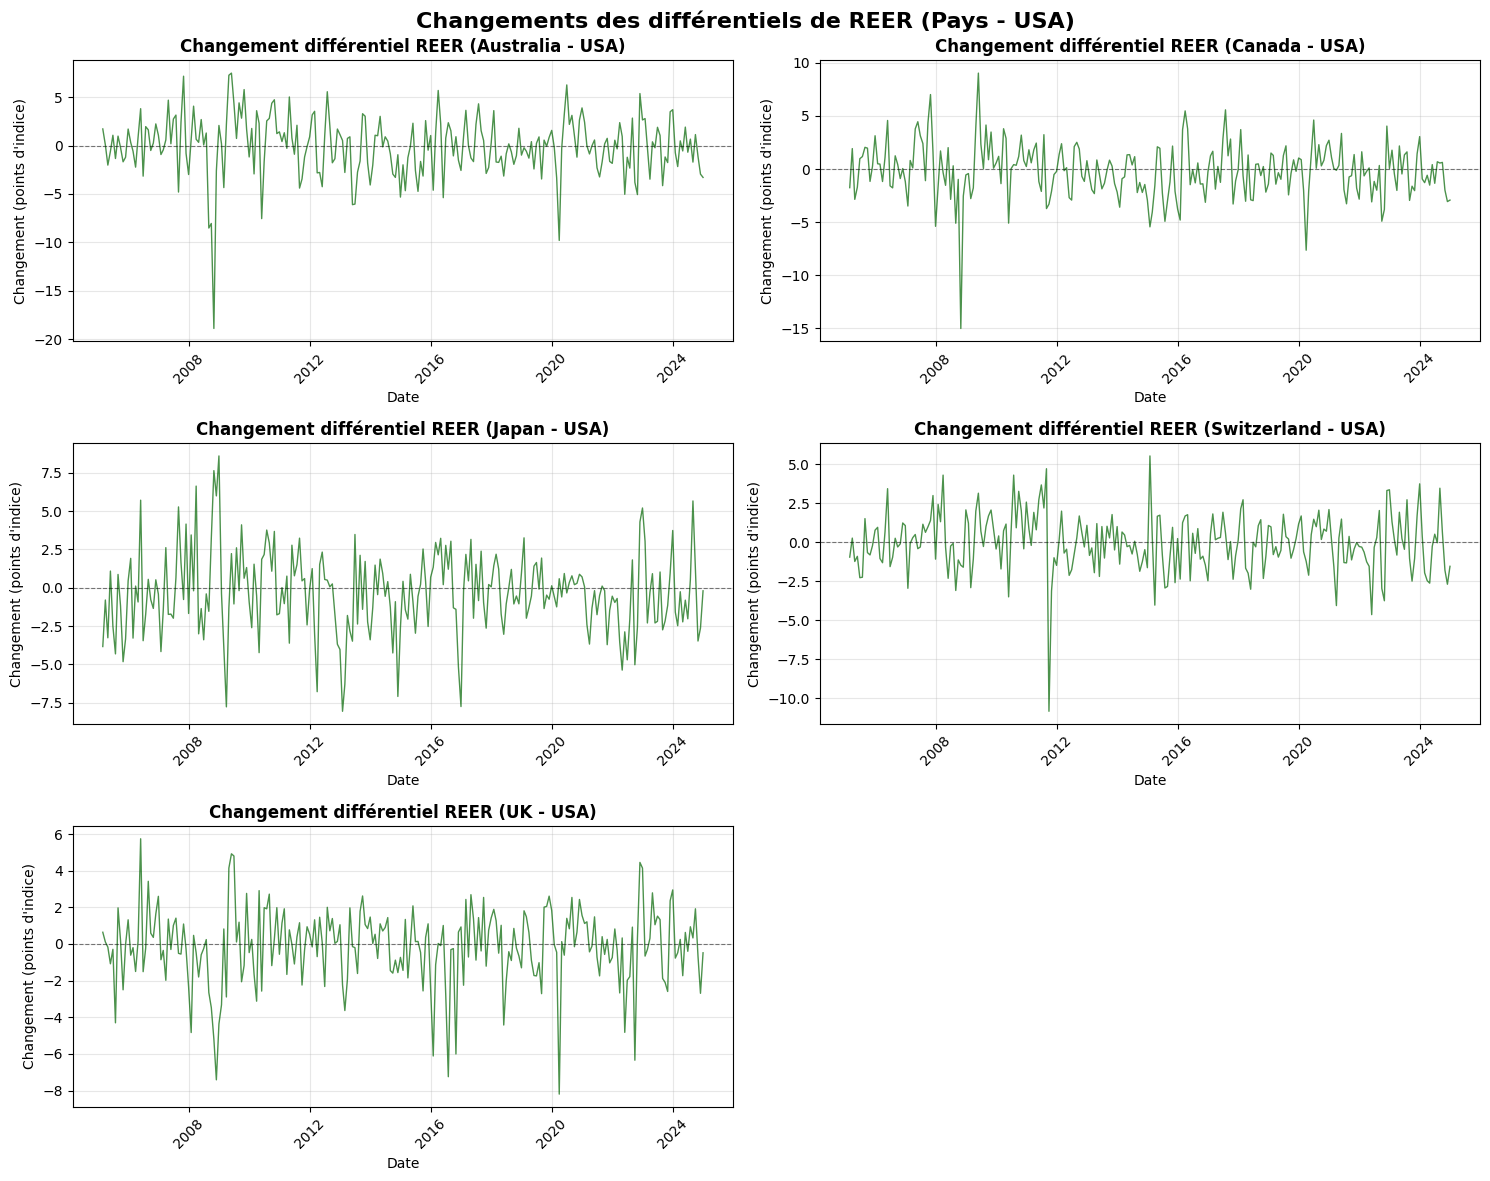

In [113]:
# Graphiques des changements de différentiels de REER
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Changements des différentiels de REER (Pays - USA)', fontsize=16, fontweight='bold')

countries = ['Australia', 'Canada', 'Japan', 'Switzerland', 'UK']

for idx, country in enumerate(countries):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    ax.plot(reer_returns['date'], reer_returns[country], linewidth=1, color='darkgreen', alpha=0.7)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.set_title(f'Changement différentiel REER ({country} - USA)', fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Changement (points d\'indice)')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

# Supprimer le dernier subplot (vide)
fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()

## 6. Justification méthodologique : Traitement des valeurs extrêmes

### 📌 Observation : Variations importantes des taux d'intérêt

Lors de l'analyse des variations de taux d'intérêt, certaines valeurs peuvent apparaître comme "extrêmes" (>50% en variation mensuelle).

### 🔍 Explication du phénomène

Ces variations ne sont **pas des erreurs** mais résultent de la **formule de calcul en pourcentage** appliquée à des niveaux très faibles :

$$\text{Variation}_t = \frac{IR_t - IR_{t-1}}{IR_{t-1}} \times 100$$

**Exemple concret** : Le Japon a maintenu des taux d'intérêt proches de **0%** pendant des décennies (politique de taux zéro).

- Si le taux passe de **0.10%** à **0.20%** :
  - Variation absolue = +0.10 point de pourcentage (minuscule)
  - Variation relative = **(0.20 - 0.10) / 0.10 × 100 = +100%** (apparemment énorme !)

- Si le taux passe de **0.50%** à **0.10%** :
  - Variation absolue = -0.40 point de pourcentage
  - Variation relative = **(0.10 - 0.50) / 0.50 × 100 = -80%**

### ✅ Pourquoi conserver ces valeurs ?

**1. Validité économique** :
- Ces variations reflètent la **réalité des politiques monétaires**
- Le Japon (et récemment la Suisse) ont effectivement connu des changements radicaux dans leurs politiques de taux
- Supprimer ou tronquer ces observations reviendrait à **censurer des événements économiques réels**

**2. Cohérence théorique** :
- Les modèles de carry trade sont **particulièrement sensibles** aux variations de taux dans les environnements de taux bas
- Une devise à taux quasi-nul qui voit ses taux doubler (même de 0.1% à 0.2%) représente un **signal important** pour les marchés

**3. Intégrité méthodologique** :
- **Aucune manipulation arbitraire** des données (pas de winsorisation, pas de suppression)
- **Transparence** : Les variations extrêmes seront documentées et expliquées dans l'analyse
- **Robustesse** : Les régressions montreront si ces valeurs sont influentes (via diagnostics de régression)

### 📊 Alternatives considérées mais écartées :

**❌ Option A : Winsorisation (couper à ±50%)** 
- Avantage : Limite l'influence des outliers
- Inconvénient : **Perte d'information**, **arbitraire**

**❌ Option B : Différences absolues (points de %) au lieu de variations %**
- Avantage : Pas de problème d'échelle
- Inconvénient : **Perte de comparabilité** entre pays (un pays à 5% vs un pays à 0.5%)

**✅ Option C retenue : Conservation + documentation**
- Justification économique des valeurs extrêmes
- Analyse de sensibilité dans les régressions
- Transparence méthodologique complète

### 🎯 Implications pour l'analyse

1. **ACP** : Les composantes principales captureront ces mouvements extrêmes s'ils sont communs à plusieurs devises
2. **Régressions** : On vérifiera les **résidus** et les **points influents** (leverage, Cook's distance)
3. **Interprétation** : Les coefficients reflèteront la sensibilité réelle aux chocs de politique monétaire, y compris dans les environnements de taux bas

### 📝 Note méthodologique pour le rapport

> "Les variations en pourcentage des taux d'intérêt présentent parfois des valeurs élevées (>50%), particulièrement pour les pays maintenant des politiques de taux proches de zéro (Japon, Suisse). Ces valeurs ne sont pas des erreurs mais reflètent les changements proportionnels importants lorsque les niveaux initiaux sont très faibles. Nous avons choisi de conserver ces observations pour préserver l'intégrité des données et capturer les effets réels des politiques monétaires non conventionnelles. Les diagnostics de régression (résidus, leverage) permettront d'identifier si ces observations sont problématiquement influentes."